In [12]:
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Imputer
from util import *
from onehot import LabelBinarizerEx
from pipeline import FeaturePipeline, DataFramePipeline
from binning import Binner
from ensemble import EnsembleStackClassifierEx
from addcols import AddColumns
from impute import GroupImputer

%matplotlib inline
from matplotlib import pyplot

## explore data

In [9]:
import pandas as pd
house_train=pd.read_csv('train.csv')
target_col='SalePrice'
id_col='Id'
target=house_train[target_col]

In [21]:
help(df.plot)

Help on FramePlotMethods in module pandas.plotting._core object:

class FramePlotMethods(BasePlotMethods)
 |  DataFrame plotting accessor and method
 |  
 |  Examples
 |  --------
 |  >>> df.plot.line()
 |  >>> df.plot.scatter('x', 'y')
 |  >>> df.plot.hexbin()
 |  
 |  These plotting methods can also be accessed by calling the accessor as a
 |  method with the ``kind`` argument:
 |  ``df.plot(kind='line')`` is equivalent to ``df.plot.line()``
 |  
 |  Method resolution order:
 |      FramePlotMethods
 |      BasePlotMethods
 |      pandas.core.base.PandasObject
 |      pandas.core.base.StringMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, yerr

In [4]:
num_summary=house_train.describe()
num_summary

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [5]:
cat_summary=house_train.describe(include=['O'])
cat_summary

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


add unit price

In [24]:
house_train['UnitPrice']=house_train[target_col]/house_train['LotArea']

explore features

In [37]:
corrs=house_train.corr()[['UnitPrice']]
corrs.sort_values('UnitPrice',ascending=False)

,UnitPrice
UnitPrice,1.000000
MSSubClass,0.527542
YearBuilt,0.392159
OverallQual,0.377578
GarageYrBlt,0.372916
YearRemodAdd,0.348566
SalePrice,0.273401
FullBath,0.244024
GarageCars,0.206168
MasVnrArea,0.201573


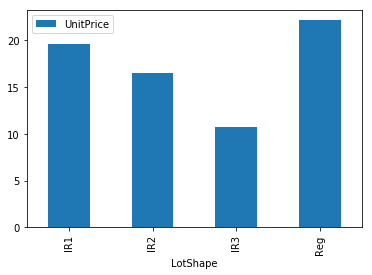

In [41]:
df=house_train.groupby('LotShape').mean()[['UnitPrice']]
df.plot(kind='bar')

LotShape is ordinal

'Reg' is max

In [46]:
corrs['UnitPrice']['LotFrontage']

-0.39294542861244491

LotFrontage is slight neg corr with up

it should be discretized

In [47]:
corrs['UnitPrice']['LotArea']

-0.32913145079857792

same with LotFrontage

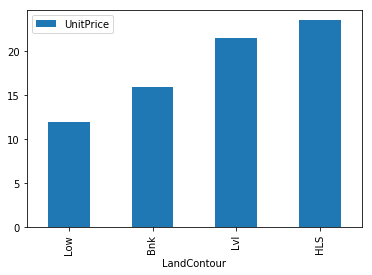

In [52]:
df=house_train.groupby('LandContour').mean()[['UnitPrice']]
df.sort_values('UnitPrice').plot(kind='bar')

make LandContour ordinal

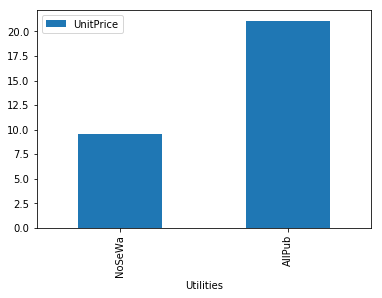

In [57]:
df=house_train.groupby('Utilities').mean()[['UnitPrice']]
df.sort_values('UnitPrice').plot(kind='bar')

make Utilities ordinal

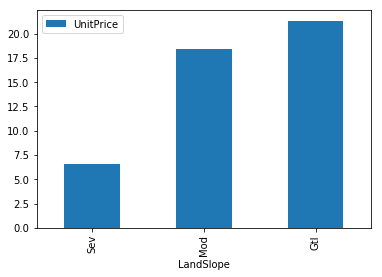

In [59]:
df=house_train.groupby('LandSlope').mean()[['UnitPrice']]
df.sort_values('UnitPrice').plot(kind='bar')

make LandSlope ordinal

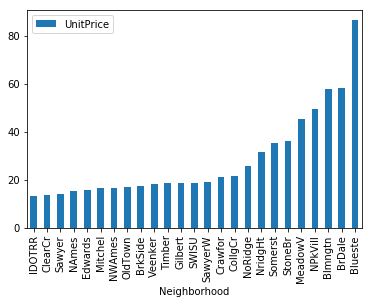

In [60]:
df=house_train.groupby('Neighborhood').mean()[['UnitPrice']]
df.sort_values('UnitPrice').plot(kind='bar')

In [50]:
help(df.plot)

Help on FramePlotMethods in module pandas.plotting._core object:

class FramePlotMethods(BasePlotMethods)
 |  DataFrame plotting accessor and method
 |  
 |  Examples
 |  --------
 |  >>> df.plot.line()
 |  >>> df.plot.scatter('x', 'y')
 |  >>> df.plot.hexbin()
 |  
 |  These plotting methods can also be accessed by calling the accessor as a
 |  method with the ``kind`` argument:
 |  ``df.plot(kind='line')`` is equivalent to ``df.plot.line()``
 |  
 |  Method resolution order:
 |      FramePlotMethods
 |      BasePlotMethods
 |      pandas.core.base.PandasObject
 |      pandas.core.base.StringMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, yerr

## feature enginering

In [ ]:
cat_pipelines=[FeaturePipeline(c,'',Pipeline([('onehot',LabelBinarizerEx([c]))])) for c in cat_summary.columns]
num_pipelines=[FeaturePipeline(c,c,Pipeline([('impute',Imputer(strategy='median')),('scale',StandardScaler())])) for c in num_summary.columns]
full_pipeline=DataFramePipeline(cat_pipelines+num_pipelines)
prepared_house_train=full_pipeline.fit_transform(house_train)
prepared_house_train.head()
prepared_house_train.drop(cat_summary.columns,axis=1,inplace=True)

In [ ]:
prepared_house_train.describe()

## train

In [ ]:
from sklearn.linear_model import SGDClassifier,LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor

base_regs=[
#     LinearRegression(n_jobs=-1),
#     SVC(probability=True),
    RandomForestRegressor(n_jobs=-1),
#     ExtraTreesRegressor(n_jobs=-1),
    GradientBoostingRegressor(),
    XGBRegressor(),
]

In [ ]:
from sklearn.model_selection import cross_val_score
from math import sqrt,log10

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

def trainModels(train_data, target):
    scores=[log10(sqrt(-cross_val_score(reg,train_data,target,scoring='neg_mean_squared_error',cv=5,n_jobs=-1,verbose=1).mean())) 
            for reg in base_regs]

    labels=[c.__class__.__name__[:3] for c in base_regs]
    X=np.arange(len(base_regs))
    bar(X,scores,tick_label=labels,color='rgb')
#     ylim(0.5,1.0)
    show()
    print(sorted(zip(labels,scores),key=lambda x:x[1],reverse=True))

In [ ]:
trainModels(prepared_house_train,target)

In [ ]:
best_reg=GradientBoostingRegressor()
best_reg.fit(prepared_house_train,target)


## tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_set=[
#                 {'C':[0.01,0.1,0.5,1.]},
#                 {'C':[1.,10.,],'kernel':['rbf','poly'],'gamma':[0.01,0.1,1.],'coef0':[1.,10.,]},
                {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
                {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300],'max_depth':[3,5,8]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300]},
#                 {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
                {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300],'max_depth':[5,10,15],'gamma':[0.01,0.1,0.5]},
               ]

def tuneModels(train_data,target):
    results=[]
    for i in range(len(base_regs)):
        gs=GridSearchCV(estimator=base_regs[i],param_grid=param_grid_set[i],scoring='neg_mean_squared_error',n_jobs=-1,verbose=1,cv=5)
        gs.fit(train_data,target)
        results.append((gs.best_estimator_,gs.best_score_))
    print(sorted(results,key=lambda x:x[1],reverse=True))
    return results

In [ ]:
results=tuneModels(prepared_house_train,target)

## test

In [43]:
house_test=pd.read_csv('test.csv')
house_test.describe()[['LotArea',id_col]]

,LotArea,Id
count,1459.000000,1459.000000
mean,9819.161069,2190.000000
std,4955.517327,421.321334
min,1470.000000,1461.000000
25%,7391.000000,1825.500000
50%,9399.000000,2190.000000
75%,11517.500000,2554.500000
max,56600.000000,2919.000000


In [ ]:
test_id=house_test[id_col]
prepared_house_test=full_pipeline.transform(house_test)
prepared_house_test.drop([id_col]+list(cat_summary.columns),axis=1,inplace=True)
prices=best_reg.predict(prepared_house_test)
df=pd.DataFrame({'Id':test_id,'SalePrice':prices})
df.to_csv('result.csv',index=False)